In [1]:
import networkx as nx
import pandas as pd

In [2]:
import numpy as np
from random import random

In [293]:
class Tournament(object):
    def __init__(self):
        # team Data
        self.team_dict = {}
        # Completed fixture Data
        self.fixture_list = []
        # Pending fixture Data
        self.pending_fixture_list = []
        # Default seed
        self.max_seed = 0
        # Points for a win
        self.win_pts = 3
        #Points for a draw
        self.draw_pts = 1
        #Points for a bye
        self.bye_pts = 3
        # Matchday Count
        self.matchday = 0
        # Minimum Possible Pairings
        self.min_pairings = 20
        # Tiebreaker
        self.tiebreaker = 'sonneborn-berger'
        # Whether to consider home and away
        self.home_away = True
        # Dummy variable for testing
        self.dummy_variable = []
    
    def add_team(self, name, seed = 'none', points = 0, more = {}):
        if seed == 'none':
            seed = self.max_seed
        
        self.team_dict[name] = {'seed': seed,
                                 'points': points,
                                 'opponents': [],
                                'home_away': [],
                                'home_away_restriction': None,
                                'home_away_gap': 0,
                                 'byes': 0, 
                                'sonneborn-berger': 0}
        
        self.team_dict[name].update(more)
        
    def teams_df(self):
        df = pd.DataFrame(self.team_dict).transpose().sample(frac = 1).sort_values(by = ['points','seed'], 
                                                                                   ascending = [False,True]).reset_index(names = 'name')
        return df
    
    # Pair all teams with no extra restrictions
    def all_fixtures(self):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        self.create_fixtures(teams_df)
    
    # Pair all teams with one filter
    def filtered_fixtures(self, filter_):
        self.matchday += 1
        # Update home/away restrictions
        for team in self.team_dict:
            self.home_away_restriction(team)
            
        teams_df = self.teams_df()
        teams_divided = [teams_df[teams_df[filter_] == x].reset_index(drop=True) for x in teams_df[filter_].drop_duplicates()]
        for teams in teams_divided:
            self.create_fixtures(teams)
        
    def create_fixtures(self, teams_df):    
        # Check whether a team needs to be given a bye
        byeNeeded = (len(teams_df) % 2 == 1)
        
        # Create a network graph
        G = nx.Graph()
        
        # Parameters for creating possible pairings
        reach = max(max(teams_df.points.value_counts()), self.min_pairings, self.matchday)
        step = max(int(reach/self.min_pairings), 1)
        
        # Add edges for each pairing of teams
        for idx, data1 in teams_df.iterrows():
            
            options = teams_df[idx + 1 : idx + reach : step]
            
            for idx2, data2 in options.iterrows():
                
                ptsGap = abs(data1['points'] - data2['points'])
                seedGap = abs(data1['seed'] - data2['seed'])
                previous_matches = data1['opponents'].count(data2['name'])
                same_restriction = (data1['home_away_restriction'] == data2['home_away_restriction']) & (data1['home_away_restriction'] != None)
                same_country = data1['country'] == data2['country']

                # weights are determined by number of previous matches, 
                # home/away restrictions, same country restrictions, points gap and seed gap
                weight = previous_matches * 1000 + same_restriction * 200 + same_country * 100 + ptsGap - seedGap/1000
                
                G.add_edge(data1['name'], data2['name'], weight = weight)
            
            # Calculate bye weights if necessary
            if byeNeeded & (len(teams_df) - idx < 101):
                pts = data1['points']
                seed = data1['seed']
                byes = data1['byes']

                weight = byes*1000 + pts - seed/1000
                G.add_edge(data1['name'],'bye', weight = weight)
            
        # Conduct minumum weight matching
        fixtures = nx.algorithms.matching.min_weight_matching(G)
        
        # Add opponent to each team, and bye count for the team with a bye
        for fixture in fixtures:
            # Weight Check
#             weight = G[fixture[0]][fixture[1]]['weight']
#             if weight > 150:
#                 print(fixture)
#                 print(weight)
            if 'bye' in fixture:
                for team in fixture:
                    if team != 'bye':
                        self.team_dict[team]['byes'] += 1
                        self.team_dict[team]['points'] += self.bye_pts
            else:
                team1, team2 = fixture[0], fixture[1]
                self.team_dict[team1]['opponents'].append(team2)
                self.team_dict[team2]['opponents'].append(team1)
                
                # Deciding which team plays home
                restriction1 = self.team_dict[team1]['home_away_restriction']
                restriction2 = self.team_dict[team2]['home_away_restriction']
                swap = False
                
                if restriction1 == None:
                    if restriction2 == None:
                        gap = self.team_dict[team1]['home_away_gap'] - self.team_dict[team2]['home_away_gap']
                        if gap > 0:
                            swap = True
                    elif restriction2 == 'home only':
                        swap = True
                    else:
                elif restriction1 == 'away only':
                    swap = True
                
                if swap:
                    final_fixture = (fixture[1], fixture[0])
                    self.team_dict[team2]['home_away'].append('home')
                    self.team_dict[team1]['home_away'].append('away')
                else:
                    final_fixture = fixture
                    self.team_dict[team1]['home_away'].append('home')
                    self.team_dict[team2]['home_away'].append('away')
                
                self.pending_fixture_list.append((final_fixture[0], final_fixture[1], self.matchday))
        
    
    def report_result(self, result, more = {}):
        # Result format: {team1: score1, team2: score2}
        
        teams = list(result.keys())
        totals = list(result.values())
        
        # Remove entry in pending fixture list
        for fixture in self.pending_fixture_list:
            if (teams[0] in fixture) & (teams[1] in fixture):
                matchday = fixture[2]
                self.pending_fixture_list.remove(fixture)
        
        # Interpret result and add points
        if totals[0] > totals[1]:
            res =  teams[0]
            self.team_dict[teams[0]]['points'] += self.win_pts
        elif totals[0] == totals[1]:
            res = 'draw'
            for team in teams:
                self.team_dict[team]['points'] += self.draw_pts
        else:
            res = teams[1]
            self.team_dict[teams[1]]['points'] += self.win_pts
        
        # Store fixture result in fixture list
        result_dict = {'Home': teams[0], 
                       'score1': totals[0], 
                       'score2': totals[1], 
                       'Away': teams[1], 
                       'Result': res, 
                       'Matchday': matchday}
        result_dict.update(more)
        self.fixture_list.append(result_dict)
        
    def fixtures_df(self, team = ''):
        df = pd.DataFrame(self.fixture_list)
        if team != '':
            df = df[(df.Home == team) | (df.Away == team)]
        return df
    
    def league_table(self):
        self.sonneborn_berger()
        df = self.teams_df().sort_values(by = ['points', self.tiebreaker, 'seed'], ascending = [False,False,True]).reset_index(drop = True)
        return df[['name','country','seed', self.tiebreaker, 'points']]
    
    def filtered_league_tables(self, filter_ = 'country'):
        df = self.league_table()
        filter_categories = df[filter_].drop_duplicates()
        
        tables_dict = {}
        for cat in filter_categories:
            tables_dict[cat] = df[df[filter_] == cat].reset_index(drop=True)
        
        return tables_dict
    
    def sonneborn_berger(self):
        for team in self.team_dict:
            tiebreaker = 0
            fixture_df = self.fixtures_df()
            results = fixture_df[(fixture_df.Home == team) | (fixture_df.Away == team)].reset_index(drop = True).Result
            opponents = self.team_dict[team]['opponents']

            for opponent, result in zip(opponents, results):
                opp_points = self.team_dict[opponent]['points']

                if result == team:
                    tiebreaker += self.win_pts * opp_points
                elif result == 'draw':
                    tiebreaker += self.draw_pts * opp_points
            
            self.team_dict[team]['sonneborn-berger'] = tiebreaker
            
    def home_away_restriction(self, team):
        data = self.team_dict[team]
        home_away_list = data['home_away']
        home_away_gap = home_away_list.count('home') - home_away_list.count('away')
        self.team_dict[team]['home_away_gap'] = home_away_gap
        restriction = None
        
        # Checks for previous 2 and 4 matches
        for check in ['home','away']:
            if ((home_away_list[-2:].count(check) == 0) & (len(home_away_list) > 1)) | ((home_away_list[-4:].count(check) == 1) & (len(home_away_list) > 3)):
                restriction = check + ' only'
#                 print(team, restriction)
        
        if restriction == None:
            # Check for overall home and away matches
            if home_away_gap == -2:
                restriction = 'home only'
            elif home_away_gap == 2:
                restriction = 'away only'
            else:
                restriction = None

        self.team_dict[team]['home_away_restriction'] = restriction

In [294]:
mymodel = np.poly1d([-0.63338287,  0.4410632 ,  0.08619369,  0.16459536])

In [295]:
def sim_fixtures(tournament):
    results = []
    weights = []
    for fixture in tournament.pending_fixture_list:
        team1, team2, weight = fixture[0], fixture[1], fixture[2]
        data1, data2 = tournament.team_dict[team1], tournament.team_dict[team2]
        elo1, elo2 = data1['elo'], data2['elo']

        score = sim_match(elo1, elo2)

        results.append({team1: score[0], team2: score[1]})
        weights.append(weight)
    return results, weights

In [296]:
def sim_match(elo1, elo2, home_coef = 1.25):
    m = elo1 - elo2
    prob = 1/(1+10**(-m/400))
    
    if home_coef != 1:
        odds = prob/(1-prob)
        new_odds = odds * home_coef
        new_prob = new_odds / (1+new_odds)
    
    draw_prob = mymodel(new_prob)
    win_prob = prob/(1-draw_prob)

    result = random()

    if win_prob - result > 0.00001:
        score = [1, 0]
    elif win_prob + draw_prob - result > 0.00001:
        score = [0.5, 0.5]
    else:
        score = [0, 1]
    
    return score

In [7]:
teams_data = pd.read_csv('teams_data.csv')

In [297]:
to = Tournament()

In [298]:
for row in teams_data.iterrows():
    team = row[1].Club
    elo = row[1].Elo
    country = row[1].Country
    seed = row[0] + 1
    
    to.add_team(team, seed, more = {'elo': elo, 'country': country})

In [299]:
# Tournament simulator
season_length = 40

for n in range(1, season_length + 1):
    if n % 2 == 0:
        to.all_fixtures()
    else:
        teams_divided = to.filtered_fixtures('country')

    results, weights = sim_fixtures(to)

    for result, weight in zip(results, weights):
        to.report_result(result, more = {'matchday': to.matchday, 'weight': weight})
    
    print('Fixture ', n)

Fixture  1
Fixture  2
Fixture  3
Fixture  4
Fixture  5
Fixture  6
Fixture  7
Fixture  8
Fixture  9
Fixture  10
Fixture  11
Fixture  12
Fixture  13
Fixture  14
Fixture  15
Fixture  16
Fixture  17
Fixture  18
Fixture  19
Fixture  20
Fixture  21
Fixture  22
Fixture  23
Fixture  24
Fixture  25
Fixture  26
Fixture  27
Fixture  28
Fixture  29
Fixture  30
Fixture  31
Fixture  32
Fixture  33
Fixture  34
Fixture  35
Fixture  36
Fixture  37
Fixture  38
Fixture  39
Fixture  40


In [300]:
league_table = to.league_table()

In [343]:
league_table[['name','points','sonneborn-berger','country']].head(50)

,name,points,sonneborn-berger,country
0,1 Man City,96,6899,ENG
1,3 Bayern,94,6695,GER
2,2 Real Madrid,88,6325,ESP
3,5 Liverpool,84,6126,ENG
4,6 Arsenal,84,6106,ENG
5,23 Porto,84,5578,POR
6,4 Inter,83,5704,ITA
7,17 Napoli,83,5697,ITA
8,7 Paris SG,83,5558,FRA
9,8 Atlético,82,5770,ESP


In [302]:
league_tables = to.filtered_league_tables()

In [342]:
league_tables['RUS'][['name','seed','points','sonneborn-berger']]

,name,seed,points,sonneborn-berger
0,67 Зенит,67,74,4658
1,Краснодар,132,67,3856
2,Динамо Москва,178,61,3452
3,Спартак Москва,168,61,3413
4,ЦСКА,143,60,3486
5,Локомотив Москва,157,59,3459
6,Ростов,229,58,3301
7,Крылья Советов,237,58,3207
8,Со́чи,344,57,3053
9,Терек,250,57,3028


In [312]:
for team in to.team_dict:
    for n in range(5):
        for check in ['home','away']:
            if to.team_dict[team]['home_away'][n:n+3].count(check) == 3:
                print(team)
                print(to.team_dict[team]['home_away'])
    

RFS
['away', 'home', 'away', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'home', 'away', 'home', 'away', 'home', 'home', 'home', 'away', 'away', 'home', 'away', 'home', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'away', 'home', 'home', 'away', 'away', 'home', 'home', 'away', 'away', 'home', 'away']
Egnatia
['home', 'home', 'away', 'away', 'away', 'home', 'home', 'away', 'away', 'home', 'home', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'away', 'home', 'away', 'home', 'home', 'away', 'away', 'home', 'away', 'home', 'away', 'away', 'home', 'away', 'home', 'away']
დინამო თბილისი
['home', 'away', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'home', 'home', 'away', 'away', 'home', 'away', 'away', 'home', 'away', 'home', 'away', 'home', 'home', 'away', 'home', 'away', 'home', 'home', 'away', 'away', 'home', 'away', 'home', 'away']
HB Tórshavn
['away

In [335]:
to.fixtures_df('Haka')

,Home,score1,score2,Away,Result,matchday,weight
272,Haka,0.0,1.0,Kuopio,Kuopio,1,99.991
578,Angers,1.0,0.0,Haka,Angers,2,-0.630
913,Haka,1.0,0.0,HJK Helsinki,Haka,3,100.991
990,Lugano,1.0,0.0,Haka,Lugano,4,-0.607
1559,Haka,0.5,0.5,Honka Espoo,draw,5,1099.916
1734,Lausanne Ouchy,1.0,0.0,Haka,Lausanne Ouchy,6,-0.579
2184,Haka,1.0,0.0,Kuopio,Haka,7,1100.991
2279,Hatayspor,1.0,0.0,Haka,Hatayspor,8,0.397
2805,Honka Espoo,1.0,0.0,Haka,Honka Espoo,9,1101.991
3090,Haka,1.0,0.0,Eupen,Haka,10,1.383


In [271]:
home_away_list = ['home', 'home', 'away', 'away', 'away']

for check in ['home','away']:
    if ((home_away_list[-2:].count(check) == 0) & len(home_away_list) > 1) | ((home_away_list[-4:].count(check) == 1) & len(home_away_list) > 3):
        restriction = check + ' only'
        print(team, restriction)

In [277]:
((home_away_list[-2:].count('home') == 0) & (len(home_away_list) > 1)) | ((home_away_list[-4:].count(check) == 1) & (len(home_away_list) > 3))

True

In [223]:
to.dummy_variable

[('1 Man City', '5 Liverpool', None, None),
 ('1 Man City', '6 Arsenal', None, None),
 ('1 Man City', '13 Aston Villa', None, None),
 ('1 Man City', '15 Tottenham', None, None),
 ('1 Man City', '20 Man United', None, None),
 ('1 Man City', '21 Newcastle', None, None),
 ('1 Man City', '22 Brighton', None, None),
 ('1 Man City', '27 West Ham', None, None),
 ('1 Man City', '32 Chelsea', None, None),
 ('1 Man City', '34 Wolves', None, None),
 ('1 Man City', '35 Brentford', None, None),
 ('1 Man City', '41 Leicester', None, None),
 ('1 Man City', '43 Everton', None, None),
 ('1 Man City', '48 Crystal Palace', None, None),
 ('1 Man City', '50 Fulham', None, None),
 ('1 Man City', '53 Bournemouth', None, None),
 ('1 Man City', '68 Forest', None, None),
 ('1 Man City', '75 Leeds', None, None),
 ('1 Man City', '80 Southampton', None, None),
 ('1 Man City', '81 Burnley', None, None),
 ('1 Man City', '87 Luton', None, None),
 ('1 Man City', 'Sheffield United', None, None),
 ('1 Man City', 'Covent

In [228]:
for team1, team2, restriction1, restriction2 in to.dummy_variable:
     if {team1, team2} == {'32 Chelsea', '5 Liverpool'}:
        print(team1, team2, restriction1, restriction2)

5 Liverpool 32 Chelsea None None
5 Liverpool 32 Chelsea None None
5 Liverpool 32 Chelsea None None


In [322]:
deltas = []

for idx, row in league_table.iterrows():
    team = row.name
    position = idx + 1
    seed = row.seed
    delta = position - seed
    deltas.append(delta)
    
league_table['position-seed delta'] = deltas 

In [323]:
league_table[:50]

,name,seed,points,opponents,home_away,home_away_restriction,home_away_gap,byes,sonneborn-berger,elo,country,position-seed delta
0,1 Man City,1,96,"[Hull, Верес, Swansea, Maribor, 35 Brentford, ...","[home, home, away, home, away, home, away, awa...",home only,1,0,6899,2051,ENG,0
1,3 Bayern,3,94,"[Hamburg, Videoton, 77 Union Berlin, Aarhus, 5...","[home, home, away, home, away, home, away, hom...",None,1,0,6695,1954,GER,-1
2,2 Real Madrid,2,88,"[Mirandes, St.Gallen, 63 Getafe, Qarabağ, 28 B...","[home, away, away, home, home, away, home, awa...",away only,1,0,6325,1972,ESP,1
3,5 Liverpool,5,84,"[Coventry, Yverdon Sport, 41 Leicester, Aris L...","[home, home, away, home, away, home, away, awa...",home only,1,0,6126,1947,ENG,-1
4,6 Arsenal,6,84,"[QPR, בית""ר, 53 Bournemouth, 70 Sparta Praha, ...","[home, home, away, away, home, home, away, awa...",None,1,0,6106,1931,ENG,-1
5,23 Porto,23,84,"[Boavista, Excelsior, 71 Braga, 87 Luton, Esto...","[home, home, away, home, away, home, away, hom...",None,-1,0,5578,1800,POR,-17
6,4 Inter,4,83,"[Pisa, נתניה, 51 Torino, Nijmegen, Cremonese, ...","[home, home, away, home, away, home, away, awa...",None,1,0,5704,1950,ITA,3
7,17 Napoli,17,83,"[Venezia, Annecy, 38 Fiorentina, Legia, Verona...","[home, away, home, home, away, home, away, hom...",None,1,0,5697,1815,ITA,-9
8,7 Paris SG,7,83,"[Troyes, Hermannstadt, Ajaccio, 49 Valencia, 4...","[home, home, away, home, away, home, away, hom...",None,1,0,5558,1879,FRA,2
9,8 Atlético,8,82,"[Villarreal B, Bordeaux, 92 Mallorca, Փյունիկ,...","[home, home, away, home, away, home, away, hom...",None,1,0,5770,1876,ESP,2


In [214]:
league_tables_by_country = to.filtered_league_tables()

In [237]:
league_tables_by_country[25]

,name,seed,points,opponents,byes,sonneborn-berger,elo,country
0,Dinamo Zagreb,177,66,"[HNK Gorica, Со́чи, Varazdin, Ботев Враца, Rud...",0,3610,1513,CRO
1,Osijek,357,65,"[Varazdin, Mura, Lok Zagreb, Karvina, Hajduk, ...",0,3512,1375,CRO
2,Hajduk,212,64,"[Rudes Zagreb, Kisvarda, Istra 1961, Eupen, Os...",0,3468,1476,CRO
3,Rijeka,283,62,"[Istra 1961, 64 Sevilla, Rudes Zagreb, 77 Unio...",0,3240,1429,CRO
4,Lok Zagreb,376,57,"[Slaven Belupo, 27 West Ham, Osijek, Alkmaar, ...",0,2908,1363,CRO
5,HNK Gorica,441,54,"[Dinamo Zagreb, Sochaux, Slaven Belupo, Penybo...",0,2716,1309,CRO
6,Istra 1961,471,52,"[Rijeka, Bohemians Praha, Hajduk, Waalwijk, HN...",0,2562,1275,CRO
7,Slaven Belupo,461,46,"[Lok Zagreb, Heerenveen, HNK Gorica, Балтика, ...",0,2170,1287,CRO
8,Varazdin,472,45,"[Osijek, Nordsjælland, Dinamo Zagreb, Rapid Wi...",0,1955,1275,CRO
9,Rudes Zagreb,579,33,"[Hajduk, Le Havre, Rijeka, Neftçi, Dinamo Zagr...",1,1113,1118,CRO


C:\Users\Usamah\AppData\Local\Temp\ipykernel_6756\1101138509.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = league_table.groupby('country').mean()


<Axes: xlabel='margins', ylabel='position-seed delta'>

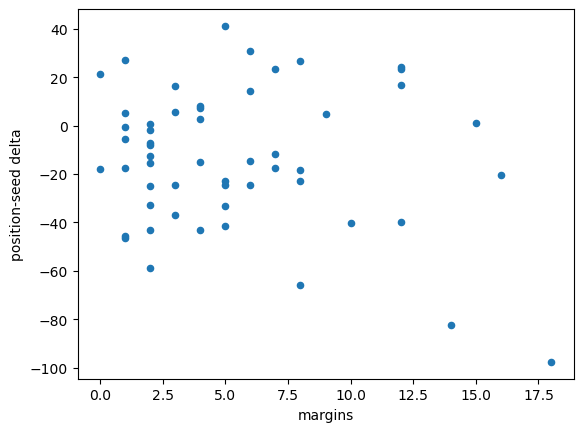

In [324]:
# Examining the relationship between league winning margin and average position-seed delta

winning_margin_dict = {}
for country in league_tables:
    table = league_tables[country]
    if len(table) > 1:
        delta = table['points'][0] - table['points'][1]
        winning_margin_dict[country] = delta
    
df = league_table.groupby('country').mean()
margins = []
for idx, row in df.iterrows():
    try:
        margins.append(winning_margin_dict[idx])
    except:
        margins.append(None)

df['margins'] = margins

df.dropna(how = 'any').plot(x = 'margins', y = 'position-seed delta',  kind = 'scatter')

In [325]:
df.sort_values(by = 'margins', ascending = False)

,position-seed delta,margins
country,,
GIB,-97.666667,18.0
AZE,-20.500000,16.0
UKR,1.250000,15.0
KOS,-82.500000,14.0
MOL,17.000000,12.0
SVN,-39.900000,12.0
GER,23.250000,12.0
ENG,24.386364,12.0
FAR,-40.250000,10.0


C:\Users\Usamah\AppData\Local\Temp\ipykernel_6756\3719136059.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))


<Axes: xlabel='country'>

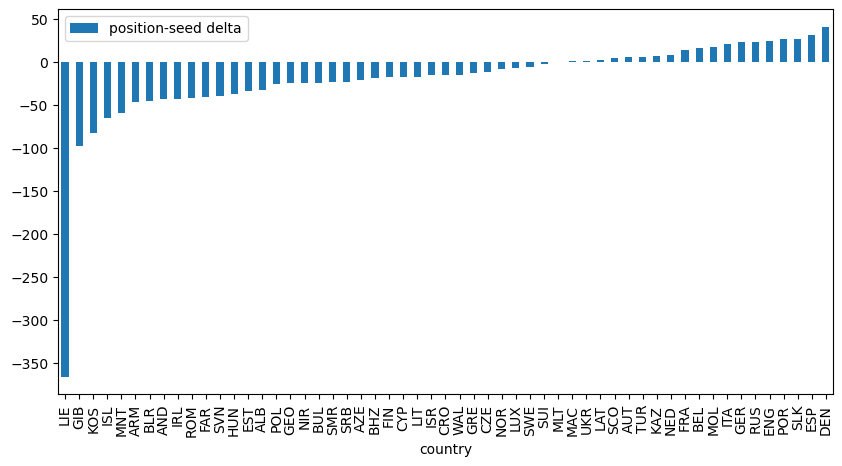

In [326]:
league_table.groupby('country').mean().sort_values(by = 'position-seed delta').plot.bar(figsize = (10,5))

In [340]:
league_table[league_table.byes > 1].sort_values('byes', ascending = False)[['name','points','country','byes']]

,name,points,country,byes
51,Vaduz,72,LIE,20
576,Sutjeska,44,MNT,7
627,Cosmos,36,SMR,7
620,College Europa,38,GIB,7
619,Atletic Club Escaldes,38,AND,7
614,La Fiorita,39,SMR,7
578,Escaldes,44,AND,7
327,Breiðablik,56,ISL,7
630,FCB Magpies,30,GIB,7
534,Podgorica,47,MNT,7


<Axes: >

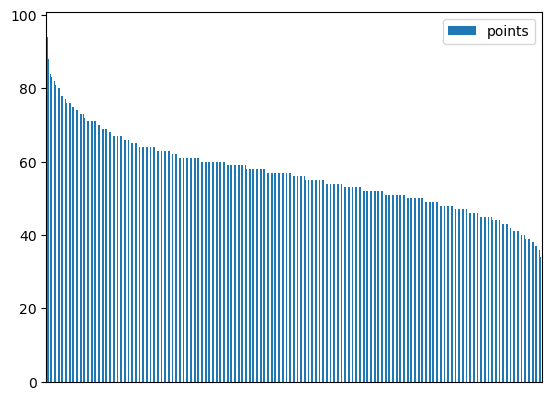

In [327]:
league_table.plot.bar(y = 'points', xticks = [])

<Axes: ylabel='Frequency'>

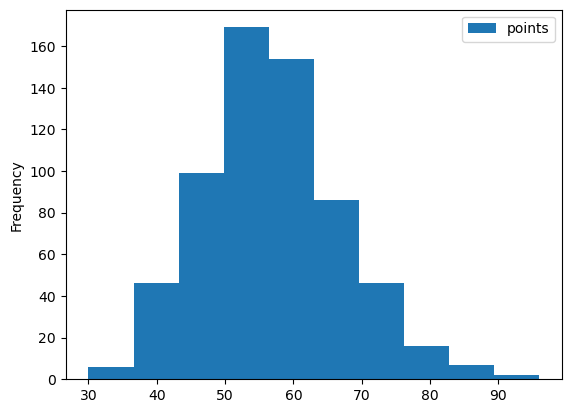

In [328]:
league_table.plot.hist(y = 'points')

In [333]:
league_table.groupby('country').min().sort_values(by = 'points', ascending = False).points

C:\Users\Usamah\AppData\Local\Temp\ipykernel_6756\3832461341.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  league_table.groupby('country').min().sort_values(by = 'points', ascending = False).points


country
LIE    72
CYP    57
ENG    52
NED    51
AZE    51
FRA    51
ITA    50
TUR    50
SLK    50
POR    50
GER    50
AUT    49
BEL    49
DEN    49
RUS    48
KAZ    47
POL    47
ISL    47
FIN    46
ESP    46
SUI    46
ISR    46
NOR    45
ALB    45
CZE    45
IRL    44
GRE    44
MOL    44
MNT    44
SWE    43
LAT    43
UKR    42
BHZ    42
MLT    41
HUN    41
BLR    41
SCO    41
GEO    41
LUX    40
EST    40
MAC    40
SVN    39
LIT    39
ARM    39
NIR    38
ROM    38
AND    38
SRB    37
CRO    37
SMR    36
FAR    36
KOS    36
BUL    34
WAL    31
GIB    30
Name: points, dtype: int64

In [344]:
import pickle

with open ('TournamentV4_sample.pickle','wb') as file:
    pickle.dump(to, file)

In [280]:
False == 0

True

In [319]:
fixtures = to.fixtures_df()

upset_list = []

for idx, row in fixtures.iterrows():
    teams, result = [row.Home, row.Away], row.Result
    seeds = [to.team_dict[x]['seed'] for x in teams]
    
    home_advantage = seeds[0] < seeds[1]
    home_result = result == teams[0]
    
    if result == 'draw':
        text = 'draw'
    else:
        if home_advantage == home_result:
            text = 'hold'
        else:
            text = 'upset'
    upset_list.append(text)

In [320]:
fixtures['upset?'] = upset_list

rate_list = []
for n in range(1, 41):
    mask = fixtures['matchday'] == n
    result_rates = fixtures[mask].value_counts(subset = 'upset?')/sum(mask)
    rate_list.append(result_rates)

<Axes: >

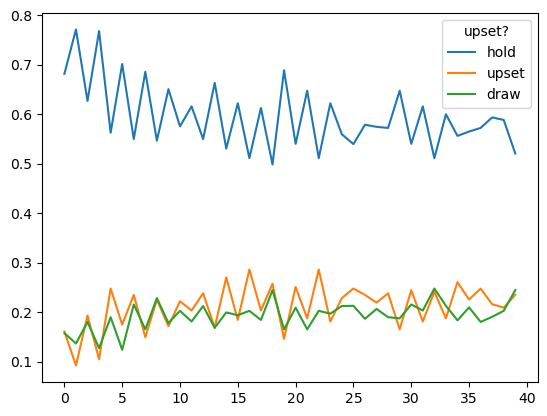

In [321]:
pd.DataFrame(rate_list).plot()

In [23]:
list_ = ['Home','Away']
restriction = list_[0] + ' Only'
restriction

'Home Only'

In [24]:
True * 1000

1000

In [96]:
None != None

False